In [1]:
%matplotlib notebook

In [1]:
import dateutil
import rosbag_pandas
import cv2
import skimage
import skimage.io
import skimage.feature
import skimage.novice
import skimage.transform

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from pypeln import thread as th
from utilities.pipeline import Compose, Handler, ForEachApply
from tf.transformations import euler_from_quaternion
from utilities.postprocessing.utils import read_image

/home/francesco/.local/lib/python3.6/site-packages/skimage/novice/__init__.py:103: UserWarning: The `skimage.novice` module was deprecated in version 0.14. It will be removed in 0.16.
  warnings.warn("The `skimage.novice` module was deprecated in version 0.14. "


In [2]:
from tqdm import tnrange, tqdm_notebook

# tdqm = tqdm_notebook

In [3]:
DATASET_DIR = '/media/francesco/saetta/krock-dataset/'

### Load Meta file
This files containes information about the stored files and the map using for that specific simulation

In [4]:
meta = pd.read_csv(DATASET_DIR + 'train/bags/meta.csv')
meta['height'] = 1 # set height to one for now
meta

,Unnamed: 0,filename,map,height
0,0,slope_rocks3-1.0-0,slope_rocks3,1
1,1,slope_rocks3-1.0-1,slope_rocks3,1
2,2,slope_rocks3-1.0-2,slope_rocks3,1
3,3,slope_rocks3-1.0-3,slope_rocks3,1
4,4,slope_rocks3-1.0-4,slope_rocks3,1
5,5,slope_rocks3-1.0-5,slope_rocks3,1
6,6,slope_rocks3-1.0-6,slope_rocks3,1
7,7,slope_rocks3-1.0-7,slope_rocks3,1
8,8,slope_rocks3-1.0-8,slope_rocks3,1
9,9,slope_rocks3-1.0-9,slope_rocks3,1


### Convert bags to dataframe
To convert each bag in a dataframe we can use the `Bags2Dataframe` combined with the `MultiThreadWrapper`

In [19]:


class MultiThreadWrapper():
    def __init__(self, n_workers, pip):
        self.n_workers = n_workers
        self.pip= pip
        
    def __call__(self, data):
        total = None
        if type(data) is list:
            total = len(data)
        return list(tqdm_notebook(th.map(self.pip, data, workers=self.n_workers), total=total))

In [29]:
class StoreDataframe():
    def __init__(self, out_dir):
        self.out_dir = out_dir 
        
    def __call__(self, data):
        df, file_name = data
        df.to_csv(self.out_dir + file_name + '.csv')
        return df

In [51]:
class Combine():
    def __init__(self, pip):
        self.pip = pip
    def __call__(self, *args):
        results = []
        for p, a in zip(self.pip, args):
            results.append(p(a))
        return zip(*results)
    
    

In [55]:
a = [1,2]
b = ['a', 'b']

res = Combine([MultiThreadWrapper(1, lambda x: x**2), 
        MultiThreadWrapper(1, lambda x: x +'s')])(a, b)


print(list(res))

[<__main__.MultiThreadWrapper object at 0x7f7bbc8f8ac8>, <__main__.MultiThreadWrapper object at 0x7f7bbc8f8828>]


[(1, 'as'), (4, 'bs')]


In [40]:
??ForEachApply

In [9]:
class Bags2Dataframe(Handler):
    """
    This class loads the bags file and converted them to Pandas' dataframe. In addition,
    it opens each map for each file and add it to the return tuple.
    """

    def __init__(self, base_dir, out_dir=None):
        self.base_dir = base_dir

    def __call__(self, file_name):
        df = rosbag_pandas.bag_to_dataframe(self.base_dir + file_name + '.bag')
        df.file_name = file_name
        return df

In [20]:
base_dir = DATASET_DIR + '/train/bags/'
out_dir = '/media/francesco/saetta/krock-dataset/train/csvs/'

convert_bags2dataframes = MultiThreadWrapper(16, Bags2Dataframe(base_dir))

In [ ]:
Combine([convert_bags2dataframes])

In [21]:
names = meta['filename'][0:20]

In [22]:
dfs = convert_bags2dataframes(names)

In [30]:
MultiThreadWrapper(16, StoreDataframe(out_dir))(Combine()(dfs, names))

[                               pose__pose_position_x  pose__pose_position_y  \
 2019-04-21 13:02:12.408817664               3.755272              -3.698457   
 2019-04-21 13:02:12.431121408               3.760090              -3.697740   
 2019-04-21 13:02:12.452356096              -4.317664              -2.239619   
 2019-04-21 13:02:12.476567040              -4.317117              -2.239158   
 2019-04-21 13:02:12.497396480              -4.318081              -2.238898   
 2019-04-21 13:02:12.522306048              -4.318964              -2.238726   
 2019-04-21 13:02:12.544794112              -4.320110              -2.238570   
 2019-04-21 13:02:12.567919104              -4.321123              -2.238482   
 2019-04-21 13:02:12.590064896              -4.322387              -2.238417   
 2019-04-21 13:02:12.613220096              -4.323675              -2.238385   
 2019-04-21 13:02:12.634227456              -4.324752              -2.238369   
 2019-04-21 13:02:12.658112000          

### Parse Dataframe
Now we need to extract informations from the dataframe to compute the advancement for a specific time window

In [35]:
class ParseDataframe(Handler):
    def convert_date2timestamp(self, df):
        """
        Convert the index column of the given dataframe which contains the converted bag time
        to a time expressed in second starting from the beginning. For example,
        1549572176.951121,
        1549572176.8528721

        becomes

        0.0,
        0.1

        :param df:
        :return:
        """
        df.index = df[df.columns[0]]
        df['ros_time'] = df.index
        df['timestamp'] = df['ros_time'].apply(lambda x: dateutil.parser.parse(str(x)).timestamp())
        df['timestamp'] -= df['timestamp'][0]
        df = df.set_index(df['timestamp'])

        return df
    
    def convert_quaterion2euler(self, df):
        """
        Decorate the given dataframe with the euler orientation computed from the existing
        quaternion.
        :param df:
        :return:
        """

        def convert(row):
            quaternion = [row['pose__pose_orientation_x'],
                          row['pose__pose_orientation_y'],
                          row['pose__pose_orientation_z'],
                          row['pose__pose_orientation_w']]


            euler = euler_from_quaternion(quaternion)

            return pd.Series(euler)

        df[['pose__pose_e_orientation_x', 'pose__pose_e_orientation_y', 'pose__pose_e_orientation_z']] = df.apply(convert,
                                                                                                                  axis=1)

        return df
    def extract_cos_sin(self, df):
        df["S_oX"] = np.cos(df['pose__pose_e_orientation_z'].values)
        df["S_oY"] = np.sin(df['pose__pose_e_orientation_z'].values)

        assert (np.allclose(1, np.linalg.norm(df[["S_oX", "S_oY"]], axis=1)))
        return df
    
    def __call__(self, df):
        df = self.convert_date2timestamp(df)
        df = self.convert_quaterion2euler(df)
        df = self.extract_cos_sin(df)
        return df
    
class AddAdvancement(Handler):
    def __init__(self, dt):
        self.dt = dt
    
    def __call__(self, df):
        """
        Project the distance x and y computed using a rolling window
        into the current line to compute the advancement
        :param df:
        :param dt:
        :return:
        """        
        # look dt in the future and compute the distance for booth axis
        df["S_dX"] = df.rolling(window=(self.dt + 1))['pose__pose_position_x'].apply(lambda x: x[-1] - x[0], raw=True).shift(
            -self.dt)
        df["S_dY"] = df.rolling(window=(self.dt + 1))['pose__pose_position_y'].apply(lambda x: x[-1] - x[0], raw=True).shift(
            -self.dt)
        # project x and y in the current line and compute the advancement
        df["advancement"] = np.einsum('ij,ij->i', df[["S_dX", "S_dY"]], df[["S_oX", "S_oY"]])  # row-wise dot product
        
        return df

class CleanDataframe(Handler):
    def __call__(self, df):
        df = df.dropna()
#       drop first second (spawn time)
        df = df.loc[df.index >= 1]
        # robot upside down
        df = df.loc[df['pose__pose_e_orientation_x'] >= -2.0].dropna()
        df = df.loc[df['pose__pose_e_orientation_x'] <= 2.0].dropna()
        df = df.loc[df['pose__pose_e_orientation_y'] >= -2.0].dropna()
        df = df.loc[df['pose__pose_e_orientation_y'] <= 2.0].dropna()
        
        return df
    
class AddHMcoordinates(Handler):
    def __init__(self, resolution=0.02, translation=[5,5]):
        self.resolution = resolution
        self.translation = translation
        
    def to_hm_coordinates(self, row, hm, res, tr=[0, 0]):
        """
        Convert robot x and y with respect to the heightmap.
        :param row:
        :param hm:
        :param res:
        :param tr:
        :return:
        """
        x, y = (row['pose__pose_position_x'], row['pose__pose_position_y'])
        x_max, y_max = hm.shape[0] * res, hm.shape[1] * res
        x_min, y_min = tr

        xs = x + x_min
        ys = -y + y_min

        return pd.Series([xs / res, ys / res])

    def __call__(self, data):
        """
        Decorate the current dataframe with the robot's position
        in the heightmap. The x and y coordinates will be stored in 'hm_x' and 'hm_y' columns.
        :param df: current dataframe
        :param hm: heightmap representing the map
        :return: decorated dataframe
        """
        df, hm = data
        df[['hm_x', 'hm_y']] = df.apply(
            lambda x: self.to_hm_coordinates(x, hm, self.resolution, self.translation),
            axis=1)
        return df

In [46]:
parsed_df_out_dir = '/media/francesco/saetta/krock-dataset/train/csvs_parsed/'
def read_csv_and_store_name(path):
    df = pd.read_csv(out_dir + path + '.csv')
    df.file_name = path
    
    return df
    
parse_df = Compose([lambda x: pd.read_csv(out_dir + x + '.csv'),
                    ParseDataframe(),
                    StoreDataframe(parsed_df_out_dir)])
parsed_dfs = MultiThreadWrapper(16, parse_df)(meta['filename'])

In [21]:
class CenterAndScalePatch():
    """
    This class is used to center in the middle and rescale a given
    patch. We need to center in the  middle in order to
    decouple the root position from the classification task. Also,
    depending on the map, we need to multiply the patch by a scaling factor.
    """

    def __init__(self, scale=1.0, debug=False, should_aug=False, resize=None):
        self.scale = scale
        self.debug = debug
        self.should_aug = should_aug
        self.resize = resize

    def show_heatmap(self, x, title, ax):
        ax.set_title(title)
        img_n = x
        sns.heatmap(img_n,
                    # vmin=0,
                    # annot=True,
                    # linewidths=.5,
                    ax=ax,
                    fmt='0.2f')

    def random_scale_aug(self, x, is_traversable):
        if not is_traversable:
            scale = 1
            if self.should_aug:
                if np.random.rand() > 0.8:
                    x, scale = random_scale(x)
                if self.debug:
                    ax = plt.subplot(2, 2, 4)
                    self.show_heatmap(x, 'scale aug scale={} class={}'.format(scale, y), ax)
                    plt.show()

    def __call__(self, x, debug=False):
        if self.debug: fig = plt.figure()


        x = x.astype(np.double)

        if self.debug:
            ax = plt.subplot(2, 2, 1)
            self.show_heatmap(x, 'original', ax)
        x *= self.scale
        if self.debug:
            ax = plt.subplot(2, 2, 2)
            self.show_heatmap(x, 'scale', ax)

        center = x[x.shape[0] // 2, x.shape[1] // 2]
        x -= center

        min, max = x.min() + 1e-5, x.max()

        if self.debug:
            print(max, min)
            ax = plt.subplot(2, 2, 3)
            self.show_heatmap(x, 'centered {}'.format(center), ax)

        if self.should_aug:
            x = (x - min) / (max - min)  # norm to 0,1 -> imgaug does not accept neg values
            x = aug.augment_image(x )
            x = x * (max - min) + min  # go back

        if self.resize is not None:
            x = cv2.resize(x, self.resize)
        if self.debug:
            ax = plt.subplot(2, 2, 4)
            self.show_heatmap(x, 'final', ax)

        if self.debug: plt.show()
        return  x.astype(np.float32)

In [22]:
class Combine():
    def __call__(self, *results):
        return list(zip(*results))

In [39]:
parsed_df_out_dir = '/media/francesco/saetta/krock-dataset/train/csvs_parsed/'
def read_csv_and_store_name(path):
    df = pd.read_csv(out_dir + path + '.csv')
    df.file_name = path
    
    return df
    
parse_df = Compose([
    read_csv_and_store_name,
#     lambda x: pd.read_csv(out_dir + x + '.csv'),
                    ParseDataframe(),
                    StoreDataframe(parsed_df_out_dir)])


In [40]:
dfs[1].head()

,pose__pose_position_x,pose__pose_position_y,pose__pose_position_z,pose__pose_orientation_x,pose__pose_orientation_y,pose__pose_orientation_z,pose__pose_orientation_w,ros_time
pose__pose_position_x,,,,,,,,
0.277830,0.277830,4.866187,-0.425565,-0.568867,0.445420,-0.619192,0.307560,0.277830
0.305851,0.305851,4.806349,-0.220463,-0.440902,0.377945,-0.770416,0.263100,0.305851
-1.742960,-1.742960,-3.388108,0.196468,0.014025,-0.013551,-0.198568,0.979893,-1.742960
-1.736828,-1.736828,-3.392364,0.189500,0.017043,-0.011705,-0.149764,0.988506,-1.736828
-1.731528,-1.731528,-3.397020,0.175969,0.020031,-0.010672,-0.103199,0.994402,-1.731528


In [42]:
parsed_dfs = MultiThreadWrapper(16, parse_df)(meta['filename'])

AttributeError: 

Original Traceback (most recent call last):
  File "/home/francesco/.local/lib/python3.6/site-packages/pypeln/thread.py", line 164, in wrapper
    return f(*args, **kwargs)
  File "/home/francesco/.local/lib/python3.6/site-packages/pypeln/thread.py", line 214, in f_task
    y = f(x, *args)
  File "/home/francesco/Documents/Master-Thesis/core/utilities/pipeline.py", line 13, in __call__
    res = handle(res)
  File "<ipython-input-7-23f4bf7aba6a>", line 6, in __call__
    df.to_csv(self.out_dir + df.file_name + '.csv')
  File "/home/francesco/.local/lib/python3.6/site-packages/pandas/core/generic.py", line 5057, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'file_name'


In [ ]:
images = MultiThreadWrapper(16, read_hm)(meta['map'])


In [ ]:
process_dfs = Compose([AddAdvancement(50 * 3), CleanDataframe()])

add_hm_coordinates = AddHMcoordinates()
read_hm = ReadHm('./maps/train/')

In [ ]:
parsed_dfs = MultiThreadWrapper(16, parse_df)(meta['filename'])


In [ ]:
parsed_dfs = MultiThreadWrapper(16, parse_df)(meta['filename'])
processed_dfs = MultiThreadWrapper(16, process_dfs)(parsed_dfs)
images = MultiThreadWrapper(16, read_image)(meta['map'])
processed_dfs = MultiThreadWrapper(16, Compose=[Combine(), 
                                                AddHMcoordinates()])(processed_dfs, images)



In [ ]:
Combine()([1,2],['a','b'],['3', '4'])

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class PatchesDataset(Dataset):
    def __init__(self, df, time_window, hm, patch_size, tr=None, transform=None):
        self.df = df
        self.hm = hm
        self.patch_size = patch_size
        self.tr = tr
        self.transform = transform
        
        self.preprocess_df = Compose([AddAdvancement(time_window), CleanDataframe()])
        self.df = self.preprocess_df(df)cd
        self.df =  AddHMcoordinates()((self.df, hm))

        if tr is not None: self.df["label"] = (self.df["advancement"] > tr)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        patch = hmpatch(self.hm, row["hm_x"], row["hm_y"], np.rad2deg(row['pose__pose_e_orientation_z']),
                        self.patch_size,
                        scale=1)[0]
        
        y = row['advancement'] 

        if 'label' in self.df: y = row['label']
        
        y = torch.tensor(y.astype(np.float32))
        
        return torch.tensor(self.transform(patch)), y
    
    def __len__(self):
        return len(self.df)
    


In [ ]:
df, hm = parsed_dfs[0], images[0]

ds = PatchesDataset(df, 50 * 3, hm, tr=None, patch_size=88, transform=CenterAndScalePatch(debug=False, should_aug=True))

print(len(df))
patch, y = ds[0]

sns.heatmap(patch)

In [ ]:
dl = DataLoader(ds, num_workers=16, batch_size=128)

for batch in dl:
    x,y = batch
    print(x)


In [ ]:
 def hmpatch(hm, x, y, alpha, edge, scale=1):
        """
        Cutout a patch from the image, centered on (x,y), rotated by alpha
        degrees (0 means bottom in hm remains bottom in patch, 90 means bottom in hm becomes right in patch),
        with a specified edge size (in pixels) and scale (relative).
        :param hm:
        :param x:
        :param y:
        :param alpha:
        :param edge:
        :param scale:
        :return:
        """
        tf1 = skimage.transform.SimilarityTransform(translation=[-x, -y])
        tf2 = skimage.transform.SimilarityTransform(rotation=np.deg2rad(alpha))
        tf3 = skimage.transform.SimilarityTransform(scale=scale)
        tf4 = skimage.transform.SimilarityTransform(translation=[+edge / 2, +edge / 2])
        tf = (tf1 + (tf2 + (tf3 + tf4))).inverse

        corners = tf(np.array([[0, 0], [1, 0], [1, 1], [0, 1], [0.5, 0.5]]) * edge)
        patch = skimage.transform.warp(hm, tf, output_shape=(edge, edge), mode="edge")
        return patch, corners
    

### Extract hm coordinates and patches
We now need to read the heightmaps and used them to computed the correct coordinates and extract the patches

In [ ]:
class ReadHm(Handler):
    def __init__(self, base_dir):
        self.base_dir = base_dir
    def __call__(self, name):
        return read_image(self.base_dir + name + '.png')
        


In [ ]:
read_images = MultiThreadWrapper(16, ReadHm('./maps/train/'))
images = read_images(meta['map'])


In [ ]:
merged = Combine()(parse_df(meta['filename']), read_images(meta['map']))

In [ ]:
MultiThreadWrapper(16, AddHMcoordinates())(merged)[0]

In [ ]:
dfs = ForEachApply([AddHMcoordinates()])(data)


In [ ]:
class ExtractPatches(Handler):
    def __init__(self, patch_size, debug=False):
        self.patch_size = patch_size
        self.debug = debug
        
    def hmpatch(self, hm, x, y, alpha, edge, scale=1):
        """
        Cutout a patch from the image, centered on (x,y), rotated by alpha
        degrees (0 means bottom in hm remains bottom in patch, 90 means bottom in hm becomes right in patch),
        with a specified edge size (in pixels) and scale (relative).
        :param hm:
        :param x:
        :param y:
        :param alpha:
        :param edge:
        :param scale:
        :return:
        """
        tf1 = skimage.transform.SimilarityTransform(translation=[-x, -y])
        tf2 = skimage.transform.SimilarityTransform(rotation=np.deg2rad(alpha))
        tf3 = skimage.transform.SimilarityTransform(scale=scale)
        tf4 = skimage.transform.SimilarityTransform(translation=[+edge / 2, +edge / 2])
        tf = (tf1 + (tf2 + (tf3 + tf4))).inverse

        corners = tf(np.array([[0, 0], [1, 0], [1, 1], [0, 1], [0.5, 0.5]]) * edge)
        patch = skimage.transform.warp(hm, tf, output_shape=(edge, edge), mode="edge")
        return patch, corners
    
    def __call__(self, data):
        df, hm, height = data
        hm = hm.copy()
        hm *= height
        to_show = 10
        
        patches = []
        for idx, (i, row) in enumerate(df.iterrows()):
            patch = \
                self.hmpatch(hm, row["hm_x"], row["hm_y"], np.rad2deg(row['pose__pose_e_orientation_z']),
                        self.patch_size,
                        scale=1)[0]

            if self.debug and i < to_show:
                fig = plt.figure()
                sns.heatmap(patch, vmin=0, vmax=1)
                plt.title('before saving')
                plt.show()

            patch = (patch * 255).astype(np.uint8)
            patches.append(patches)
        
        return patches
    
# class StorePatches():
#     def __init__():
#         pass
    
#     def __call__(self, data):
#         file_name, patches = data
        
        

In [113]:
def foo(data):
    df = data[0]
    pass 

foo([1,2,3])

In [112]:
class OpenDfAndStoreName():
    def __call__(self, path):
        df = pd.read_csv(path)
        df.name = path
        return df 


In [135]:
df = pd.read_csv('/media/francesco/saetta/krock-dataset/train/csvs_parsed/rails2-1.0-0.csv')
df = Compose([AddAdvancement(50*2), CleanDataframe()])(df)

In [136]:
df

,timestamp,Unnamed: 0,pose__pose_position_x,pose__pose_position_y,pose__pose_position_z,pose__pose_e_orientation_x,pose__pose_e_orientation_y,pose__pose_e_orientation_z,S_oX,S_oY,hm_x,hm_y,S_dX,S_dY,advancement
1,0.022907,2019-04-21 13:37:38.839851008,2.918027,-2.080238,0.472769,0.003045,0.001025,-1.155696,0.403281,-0.915076,395.901353,354.011911,0.089045,-0.182514,0.202924
2,0.049006,2019-04-21 13:37:38.865950464,2.917958,-2.080181,0.453525,0.003732,0.000917,-1.156049,0.402958,-0.915218,395.897881,354.009050,0.091156,-0.186717,0.207618
3,0.071005,2019-04-21 13:37:38.887949824,2.917912,-2.080143,0.433162,0.004190,0.000845,-1.156283,0.402744,-0.915312,395.895607,354.007133,0.092839,-0.190978,0.212196
4,0.095553,2019-04-21 13:37:38.912497152,2.917869,-2.080106,0.403536,0.004630,0.000776,-1.156507,0.402540,-0.915403,395.893452,354.005282,0.094526,-0.196091,0.217553
5,0.118780,2019-04-21 13:37:38.935724032,2.917836,-2.080077,0.368251,0.004974,0.000722,-1.156682,0.402380,-0.915473,395.891784,354.003827,0.094749,-0.200819,0.221969
6,0.140784,2019-04-21 13:37:38.957728512,2.917810,-2.080054,0.327309,0.005244,0.000680,-1.156818,0.402255,-0.915528,395.890489,354.002683,0.093366,-0.204856,0.225108
7,0.162281,2019-04-21 13:37:38.979225600,2.917793,-2.080038,0.288870,0.005423,0.000652,-1.156909,0.402172,-0.915564,395.889633,354.001920,0.093349,-0.208905,0.228808
8,0.185635,2019-04-21 13:37:39.002579968,2.917776,-2.080024,0.237560,0.005595,0.000625,-1.156996,0.402092,-0.915599,395.888816,354.001187,0.095058,-0.215662,0.235682
9,0.208984,2019-04-21 13:37:39.025928448,2.917764,-2.080012,0.180595,0.005730,0.000604,-1.157064,0.402030,-0.915627,395.888179,354.000612,0.096689,-0.220782,0.241026
10,0.229208,2019-04-21 13:37:39.046152960,2.917755,-2.080005,0.128806,0.005820,0.000590,-1.157109,0.401988,-0.915645,395.887757,354.000229,0.099423,-0.228453,0.249148


In [8]:
meta_bars1 = meta[meta['map'] == 'bars1']

In [26]:
def foo(a, *args, **kwargs):
    print(a)
    
foo(*[1,2])

1


In [2]:
meta = pd.read_csv('/media/francesco/saetta/krock-dataset/test/bags/meta.csv')


In [3]:
dfs = [pd.read_csv('/media/francesco/saetta/krock-dataset/test/csvs_parsed/' + x['filename'] + '.csv') for idx,x in meta.iterrows()]

In [ ]:
dfs

In [4]:
from utilities.visualisation import DataFrameVisualization, PatchesAndDataframeVisualization

DataFrameVisualization(df)(0.45)

NameError: name 'df' is not defined

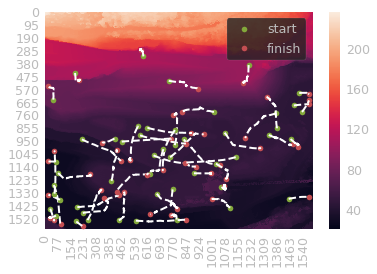

In [8]:
PatchesAndDataframeVisualization(dfs[0], hm=read_image('/home/francesco/Documents/Master-Thesis/core/maps/test/querry-big-10.png')).show_traces(dfs)
plt.show()

In [46]:
total = total.reset_index()

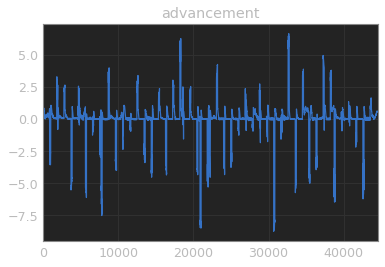

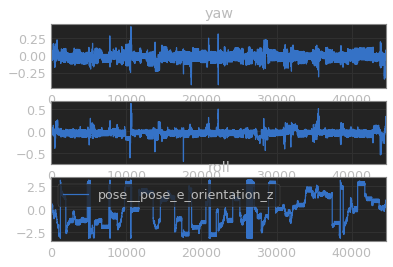

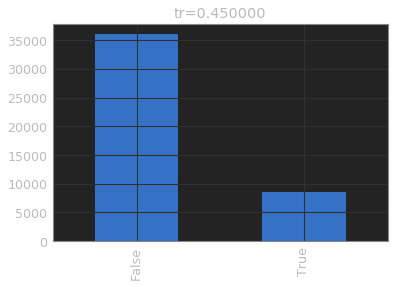

In [53]:
DataFrameVisualization(AddAdvancement(150)(total))(0.45)

In [118]:
rosbag_pandas.bag_to_dataframe('/media/francesco/saetta/krock-dataset/train/bags/bars1-1.0-0.bag')

,pose__pose_position_x,pose__pose_position_y,pose__pose_position_z,pose__pose_orientation_x,pose__pose_orientation_y,pose__pose_orientation_z,pose__pose_orientation_w
2019-04-21 14:37:27.631851264,-4.280131,-0.160085,0.200870,0.000205,-0.000179,0.196627,0.980478
2019-04-21 14:37:27.654829312,-4.280153,-0.160099,0.195739,0.000352,-0.000192,0.196563,0.980491
2019-04-21 14:37:27.676564480,-4.280168,-0.160107,0.187138,0.000450,-0.000202,0.196521,0.980500
2019-04-21 14:37:27.697161472,-4.280183,-0.160116,0.171630,0.000544,-0.000210,0.196480,0.980508
2019-04-21 14:37:27.719311104,-4.280192,-0.160121,0.154385,0.000606,-0.000216,0.196453,0.980513
2019-04-21 14:37:27.740122880,-4.280201,-0.160127,0.128506,0.000666,-0.000221,0.196428,0.980518
2019-04-21 14:37:27.762910208,-4.280207,-0.160130,0.102621,0.000706,-0.000225,0.196410,0.980521
2019-04-21 14:37:27.783934208,-4.280213,-0.160133,0.066376,0.000744,-0.000229,0.196394,0.980525
2019-04-21 14:37:27.805090816,-4.280217,-0.160136,0.031853,0.000769,-0.000231,0.196383,0.980527
2019-04-21 14:37:27.827921920,-4.280220,-0.160138,-0.006595,0.000790,-0.000233,0.196374,0.980529


In [119]:
df = rosbag_pandas.bag_to_dataframe('/home/francesco/Desktop/flat-1.0-0.bag')
hm = read_image('/home/francesco/Documents/Master-Thesis/core/maps/test/flat.png')



df = ParseDataframe()(df)

KeyError: 0.0

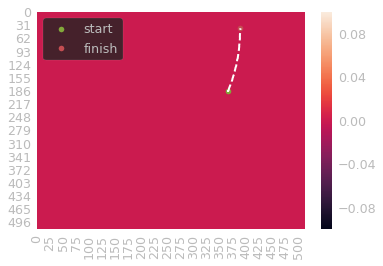

In [98]:
df = AddHMcoordinates()((df, hm))

PatchesAndDataframeVisualization(df, hm=hm).show_traces([df])

In [86]:
'/home/francesco/Desktop/flat-1.0-0.bag'Compose([lambda x: rosbag_pandas.bag_to_dataframe(x), ParseDataframe()])()

KeyError: 0.0

In [51]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
from utilities.visualisation import DataFrameVisualization, PatchesAndDataframeVisualization
from utilities.postprocessing.postprocessing import AddAdvancement
from utilities.pipeline import ForEachApply
import glob

dfs_paths = glob.glob('/home/francesco/Desktop/test/' + '/*.csv')
if len(dfs_paths) <= 0: dfs_paths = glob.glob(root + '/**/*.csv')
dfs = [pd.read_csv(df_paths) for df_paths in dfs_paths]
        
res = []

for df in dfs:
    res.append(AddAdvancement(50)(df))

df_vis = DataFrameVisualization.from_dfs(dfs)
# df_vis(0.45)
print(df_vis.df['advancement'].mean() / 2)

0.1673948825046576


In [31]:
res[2]['advancement'].plot()

NameError: name 'res' is not defined

In [ ]:
x = AddAdvancement(50 * 3)(x)

In [ ]:
x['advancement'].plot.box()